# Классификация вторая часть

## Щека Дмитрий, 24.М41

В качестве датасета я взял датасет про решение о взятии претендента на работу: https://www.kaggle.com/datasets/rabieelkharoua/predicting-hiring-decisions-in-recruitment-data

Описание датасета:

#### Age
Age of the candidate.

#### Gender
Male (0) or Female (1).

#### Education Level

1: Bachelor's (Type 1)

2: Bachelor's (Type 2)

3: Master's

4: PhD

####  Experience Years
Number of years of professional experience.


#### Previous Companies Worked
Number of previous companies where the candidate has worked.

#### Distance From Company
Distance in kilometers from the candidate's residence to the hiring company.

#### Interview Score
Score achieved by the candidate in the interview process.

#### Skill Score
Assessment score of the candidate's technical skills.

#### Personality Score
Evaluation score of the candidate's personality traits.

#### Recruitment Strategy
Strategy adopted by the hiring team for recruitment.

1: Aggressive

2: Moderate

3: Conservative

#### Hiring Decision (Target Variable)
Outcome of the hiring decision.

0: Not hired

1: Hired

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [2]:
df = pd.read_csv('recruitment_data.csv')
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


# EDA

In [3]:
df.groupby('HiringDecision').mean()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy
HiringDecision,,,,,,,,,,
0,35.137198,0.492754,2.051208,7.313043,2.960386,25.669273,47.762319,47.110145,46.059903,2.114010
1,35.174194,0.490323,2.492473,8.541935,3.094624,25.140583,56.800000,60.032258,56.793548,1.402151


In [4]:
df['HiringDecision'].mean()

0.31

Решение нанять было принято в 31% случаев. Это информация потом будет нужна для Наивного Байеса

# Первичный анализ признаков

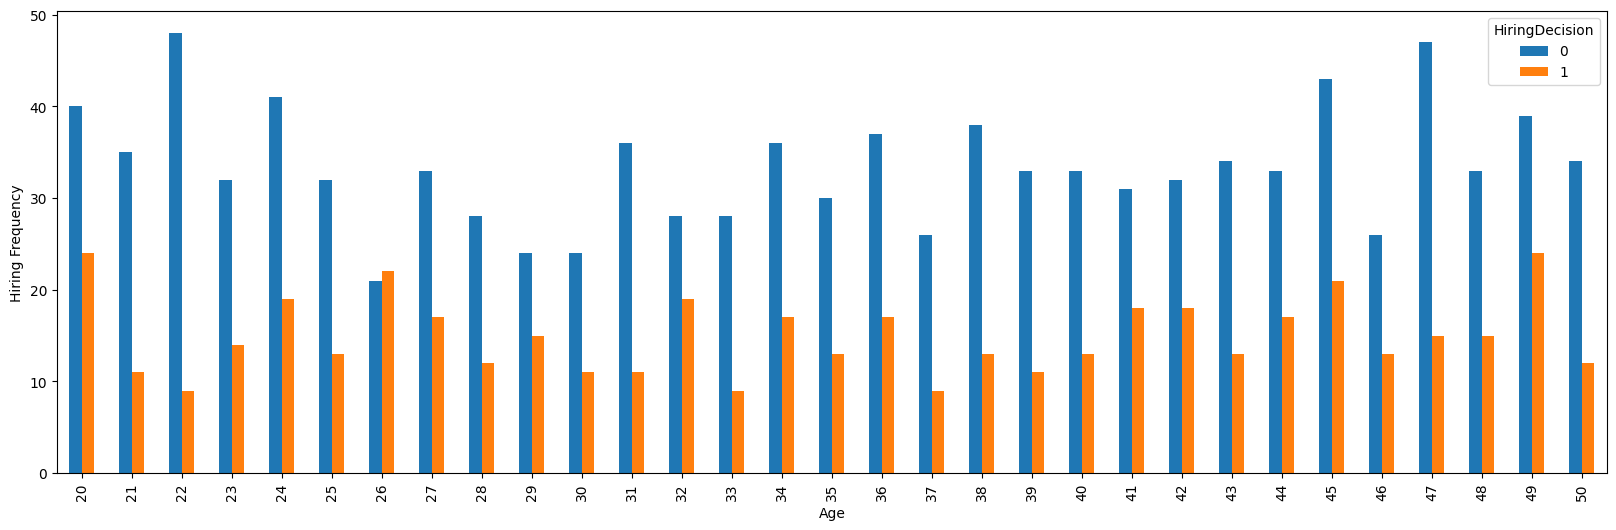

In [5]:
pd.crosstab(df['Age'],df['HiringDecision']).plot(kind="bar", figsize=(20, 6))
plt.xlabel('Age')
plt.ylabel('Hiring Frequency')
plt.show()

Датасет синтетический, так что вряд ли будут суперинтересные зависимости. Но для 26 лет зато видно, что нанимали чаще, чем отказывали

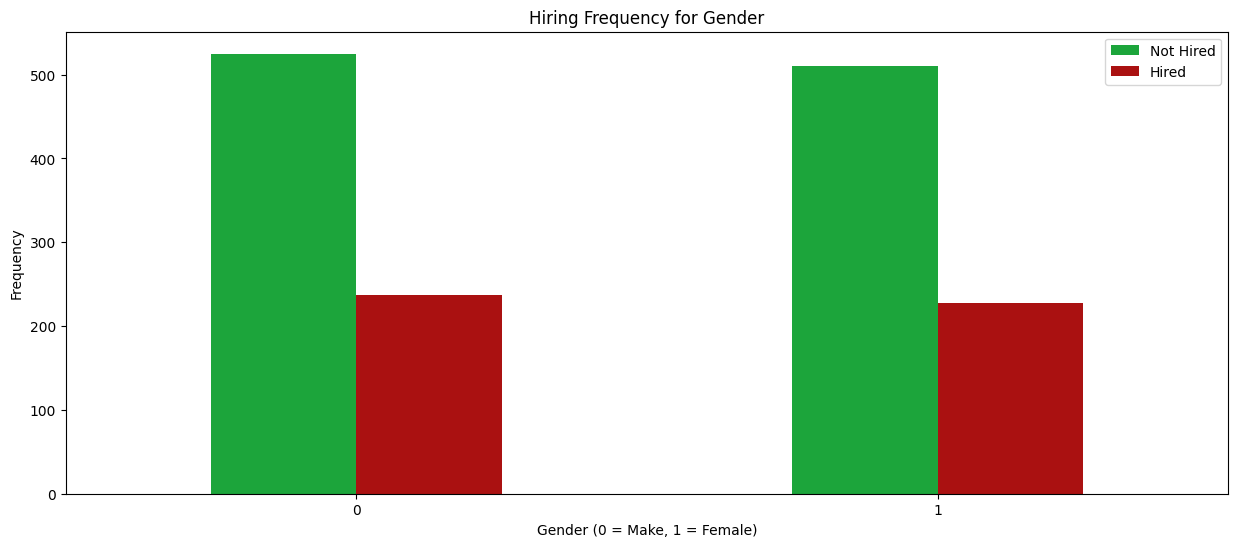

In [6]:
pd.crosstab(df['Gender'],df['HiringDecision']).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Hiring Frequency for Gender')
plt.xlabel('Gender (0 = Make, 1 = Female)')
plt.xticks(rotation=0)
plt.legend(["Not Hired", "Hired"])
plt.ylabel('Frequency')
plt.show()

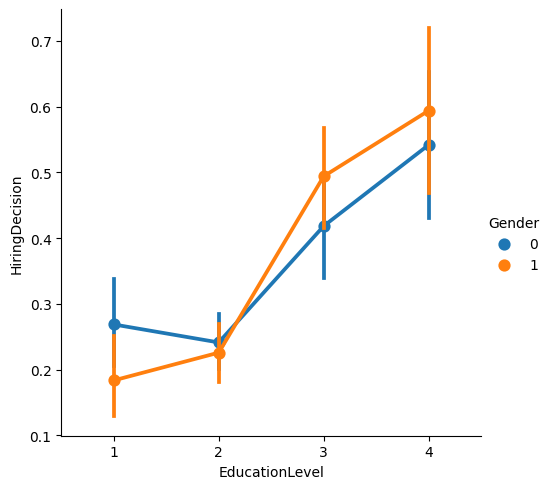

In [7]:
sns.catplot(x='EducationLevel', y='HiringDecision', hue='Gender', data=df, kind="point");

Тут уже интереснее. Потому что бакалавров нанимают примерно одинаково (может мужчин чуть-чаще), но среди магистров и кандидатов нанимается больше женщин

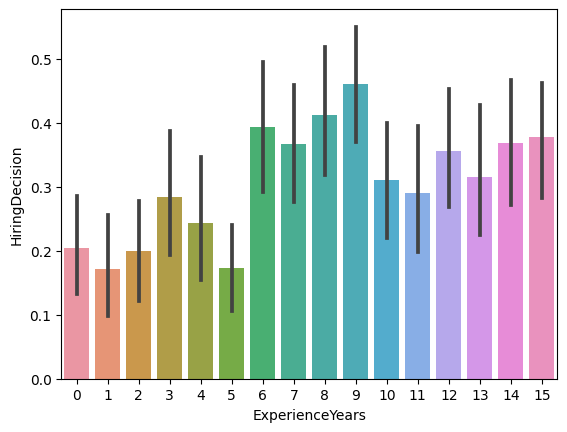

In [8]:
sns.barplot(x='ExperienceYears', y='HiringDecision', data=df);

Тут закономерно, меньше опыта -- реже нанимают

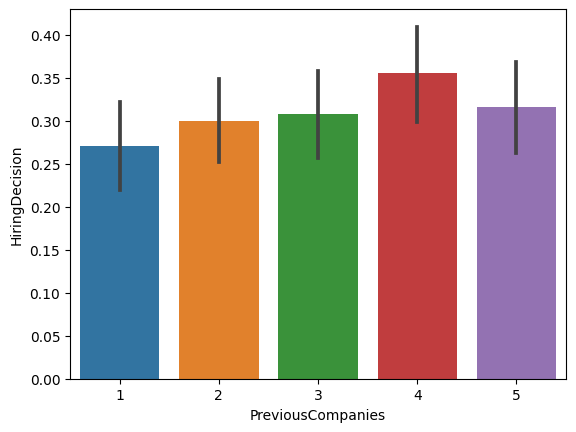

In [9]:
sns.barplot(x='PreviousCompanies', y='HiringDecision', data=df);

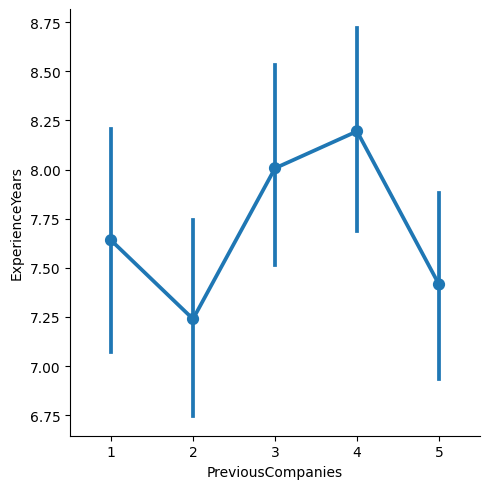

In [10]:
sns.catplot(x='PreviousCompanies', y='ExperienceYears', data=df, kind="point");

Я думал, что будет зависимость между количеством бывших работодателей и опытом, ну ладно.

<AxesSubplot:xlabel='Gender', ylabel='DistanceFromCompany'>

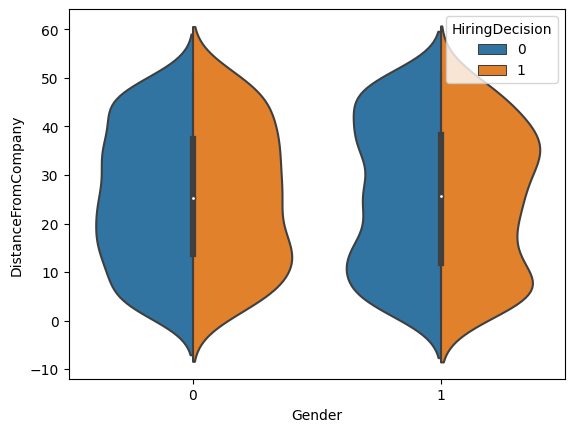

In [11]:
sns.violinplot(x="Gender", y="DistanceFromCompany", hue="HiringDecision", data=df, split=True)

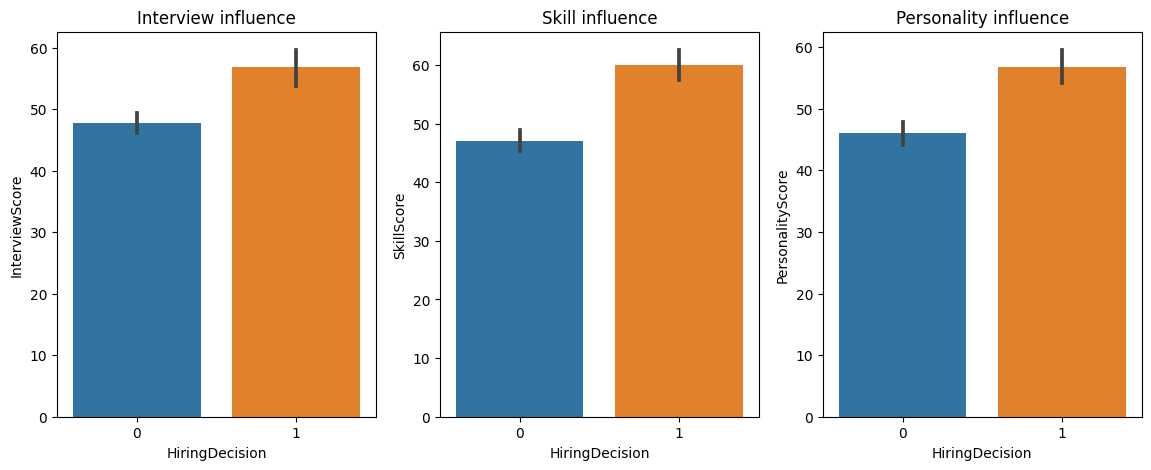

In [12]:
_, ax = plt.subplots(1, 3, figsize=(14,5))
sns.barplot(x='HiringDecision', y='InterviewScore', data=df, ax=ax[0]);
ax[0].set_title('Interview influence')
sns.barplot(x='HiringDecision', y='SkillScore', data=df, ax=ax[1]);
ax[1].set_title('Skill influence')
sns.barplot(x='HiringDecision', y='PersonalityScore', data=df, ax=ax[2]);
ax[2].set_title('Personality influence')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

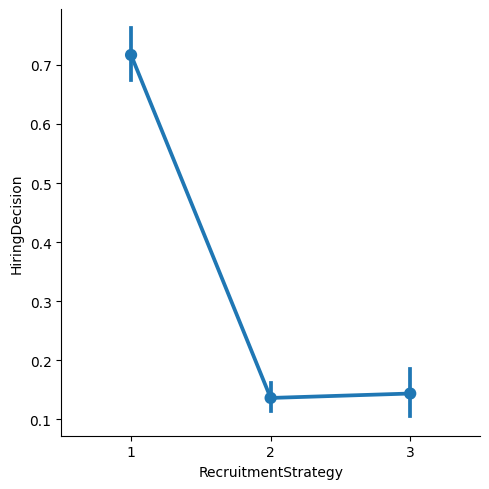

In [13]:
sns.catplot(x='RecruitmentStrategy', y='HiringDecision', data=df, kind="point"); 

## Разбиение данных с использованием train_test_split и масштабирование

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['HiringDecision']
X = df.drop(columns=['HiringDecision'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.model_selection import RepeatedStratifiedKFold

accuracies = {}

C = np.arange(1e-05, 5, 0.1)

rskfold = RepeatedStratifiedKFold(n_splits=4, random_state=0)

log_clf = GridSearchCV(estimator=LogisticRegression(), cv=rskfold,
              scoring='accuracy', return_train_score=True,
              param_grid={'C':C})

log_clf.fit(X_train_scaled, y_train)
acc = log_clf.score(X_test_scaled, y_test)
accuracies['LogR'] = acc
print("best params: " + str(log_clf.best_params_))
print("Test Accuracy {:.4f}".format(acc))

best params: {'C': 0.10001}
Test Accuracy 0.8622


## K-Nearest Neighbour (KNN) Classification

In [16]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 11, 2) 
weights = ['uniform', 'distance'] 

rskfold = RepeatedStratifiedKFold(n_splits=4, random_state=1)

knn_clf = GridSearchCV(estimator=KNeighborsClassifier(), cv=rskfold,
              scoring='accuracy', return_train_score=True,
              param_grid={'n_neighbors':n_neighbors, 'weights':weights})

knn_clf.fit(X_train_scaled, y_train)
acc = knn_clf.score(X_test_scaled, y_test)
accuracies['KNN'] = acc
print("best params: " + str(knn_clf.best_params_))
print("Test Accuracy {:.4f}".format(acc))

best params: {'n_neighbors': 3, 'weights': 'uniform'}
Test Accuracy 0.8311


## Support Vector Machine (SVM)

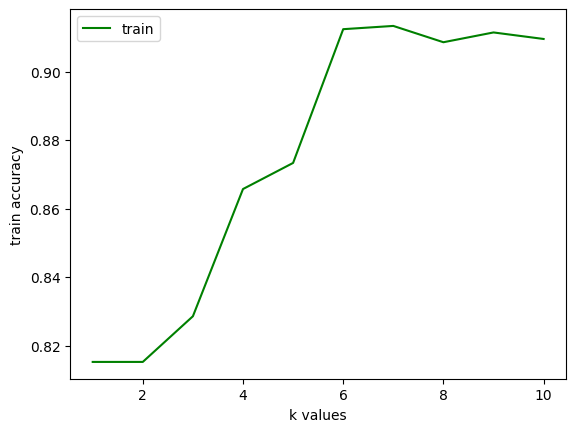

In [17]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

svm = SVC(random_state=11)

accuracy_list_train = []
k = np.arange(1, len(df.columns))

for i in k:
    x_new = SelectKBest(f_classif, k=i).fit_transform(X_train_scaled, y_train)
    svm.fit(x_new, y_train)
    accuracy_list_train.append(svm.score(x_new, y_train))   
    
plt.plot(k,accuracy_list_train, color="green", label="train")
plt.xlabel("k values")
plt.ylabel("train accuracy")
plt.legend()
plt.show()

Ну как будто если больше 6, то норм. Оставлю все

In [18]:
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

rskfold = RepeatedStratifiedKFold(n_splits=4, random_state=2)

grid_svm = GridSearchCV(estimator=svm, cv=rskfold, 
        param_grid=dict(kernel=kernel,C=C, gamma=gamma),refit='Accuracy')

grid_svm.fit(X_train_scaled, y_train)
acc = grid_svm.score(X_test_scaled, y_test)
accuracies['SVM'] = acc
print("best params: " + str(grid_svm.best_params_))
print("Test Accuracy {:.4f}".format(acc))

best params: {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy 0.8822


## Naive Bayes Algorithm

In [19]:
from sklearn.naive_bayes import GaussianNB

priors = [None, [0.31, 0.69]]
var_smoothing = np.logspace(0, -9, num=100) # portion of the largest variance of all features that is added to variances for calculation stability

rskfold = RepeatedStratifiedKFold(n_splits=4, random_state=3)

nb_clf = GridSearchCV(estimator=GaussianNB(), cv=rskfold,
              scoring='accuracy', return_train_score=True,
              param_grid={'priors':priors, 'var_smoothing':var_smoothing})

nb_clf.fit(X_train_scaled, y_train)
acc = nb_clf.score(X_test_scaled, y_test)
accuracies['NB'] = acc
print("best params: " + str(nb_clf.best_params_))
print("Test Accuracy {:.4f}".format(acc))

best params: {'priors': None, 'var_smoothing': 0.004328761281083057}
Test Accuracy 0.8867


## Decision Tree Algorithm

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9]
min_samples_split = [2, 4, 6, 10]
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12]
max_features = np.arange(2, 11, 2)

skfold = StratifiedKFold(n_splits=4)

decision_tree = DecisionTreeClassifier(random_state=81)
grid_dt = GridSearchCV(estimator=decision_tree, cv=skfold, 
        param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                        max_features= max_features), refit='Accuracy')

grid_dt.fit(X_train, y_train)
acc = grid_dt.score(X_test, y_test)
accuracies['DT'] = acc
print("best params: " + str(grid_dt.best_params_))
print("Test Accuracy {:.4f}".format(acc))

best params: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'best'}
Test Accuracy 0.9222


# Реализация KNN

In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MyKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights

    def fit(self, X_train, y_train):
        self.X_train, self.y_train = X_train, y_train

    def distance(self, x_train_i, x_test_i):
        return np.sqrt(np.sum((x_train_i - x_test_i) ** 2))

    def make_prediction(self, x_test_i):
        distances = []
        for x in self.X_train:
            distances.append(self.distance(x, x_test_i))
        k_nearest_indexes = np.argsort(distances)[:self.n_neighbors]
        targets = []
        y_list = self.y_train.to_list()
        for ind in k_nearest_indexes:
            targets.append(y_list[ind])
        
        if self.weights == 'distance':
            closest_distance = distances[k_nearest_indexes[0]]
            weighted_targets = {}
            for index in k_nearest_indexes:
                if targets[index] not in weighted_targets:
                    weighted_targets[targets[index]] = 0.0
                weighted_targets[targets[index]] += distances[index] / closest_distance
            return max(weighted_targets, key=weighted_targets.get)
        
        return np.bincount(targets).argmax()
    
    def predict(self, X_test):
        return np.array([self.make_prediction(x) for x in X_test])

In [22]:
n_neighbors = np.arange(1, 11, 2) 
weights = ['uniform', 'distance'] 

rskfold = RepeatedStratifiedKFold(n_splits=4, random_state=5)

myknn_clf = GridSearchCV(estimator=MyKNN(), cv=rskfold,
              scoring='accuracy', return_train_score=True,
              param_grid={'n_neighbors':n_neighbors, 'weights':weights})

myknn_clf.fit(X_train_scaled, y_train)
y_pred = myknn_clf.predict(X_test_scaled)
acc = accuracy_score(y_pred, y_test)
accuracies['MyKNN'] = acc
print("best params: " + str(myknn_clf.best_params_))
print("Test Accuracy {:.4f}".format(acc))

best params: {'n_neighbors': 1, 'weights': 'uniform'}
Test Accuracy 0.8267


# Реализация Logistic Regression

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial import distance

class MyLogRegression(BaseEstimator, ClassifierMixin): 
    def __init__(self, learning_rate = 1, tol = 0.01):         
        self.learning_rate = learning_rate 
        self.tol = tol
           
    def fit(self, X, Y):                  
        self.m, self.n = X.shape         
        self.W = np.zeros(self.n)         
        self.b = 0        
        self.X = X         
        self.Y = Y 
        
        i = 1
        while(self.update_weights(i)):
            i += 1
            
        return self
      
    def update_weights(self, i) :            
        A = 1 / (1 + np.exp(-(self.X.dot(self.W) + self.b))) 
                  
        tmp = (A - self.Y.T)         
        tmp = np.reshape(tmp, self.m)         
        dW = np.dot(self.X.T, tmp) / self.m          
        db = np.sum(tmp) / self.m  
        
        new_W = self.W - self.learning_rate * (1/np.sqrt(i)) * dW 
        new_b = self.b - self.learning_rate * (1/np.sqrt(i)) * db 
        if (distance.euclidean(new_W, self.W) + abs(new_b - self.b) < self.tol):
            return False
        
        self.W = new_W    
        self.b = new_b
          
        return True
      
    def predict(self, X):     
        Z = 1 / (1 + np.exp(-(X.dot(self.W) + self.b)))         
        Y = np.where(Z > 0.5, 1, 0)         
        return Y 

In [24]:
tol = np.logspace(-3, 0, 6)
learning_rate = np.logspace(-1, 1, 6, base=2)

rskfold = RepeatedStratifiedKFold(n_splits=4, random_state=6)

mylog_clf = GridSearchCV(estimator=MyLogRegression(), cv=rskfold,
              scoring='accuracy', return_train_score=True,
              param_grid={'tol':tol, 'learning_rate':learning_rate})

mylog_clf.fit(X_train_scaled, y_train)
y_pred = mylog_clf.predict(X_test_scaled)
acc = accuracy_score(y_pred, y_test)
accuracies['MyLogR'] = acc
print("best params: " + str(mylog_clf.best_params_))
print("Test Accuracy {:.4f}".format(acc))

best params: {'learning_rate': 0.5, 'tol': 0.001}
Test Accuracy 0.8622


## Comparing Models

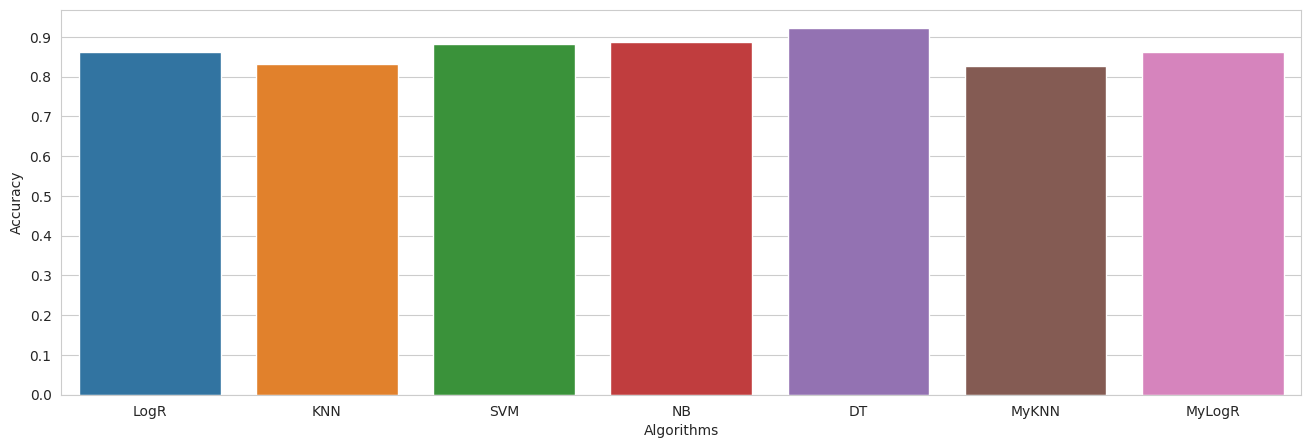

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

## Confusion Matrix

In [26]:
# Predicted values
y_head_lr = log_clf.predict(X_test_scaled)
y_head_mylr = mylog_clf.predict(X_test_scaled)
y_head_knn = knn_clf.predict(X_test_scaled)
y_head_myknn = myknn_clf.predict(X_test_scaled)
y_head_svm = grid_svm.predict(X_test_scaled)
y_head_nb = nb_clf.predict(X_test_scaled)
y_head_dtc = grid_dt.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_mylr = confusion_matrix(y_test, y_head_mylr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_myknn = confusion_matrix(y_test, y_head_myknn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)

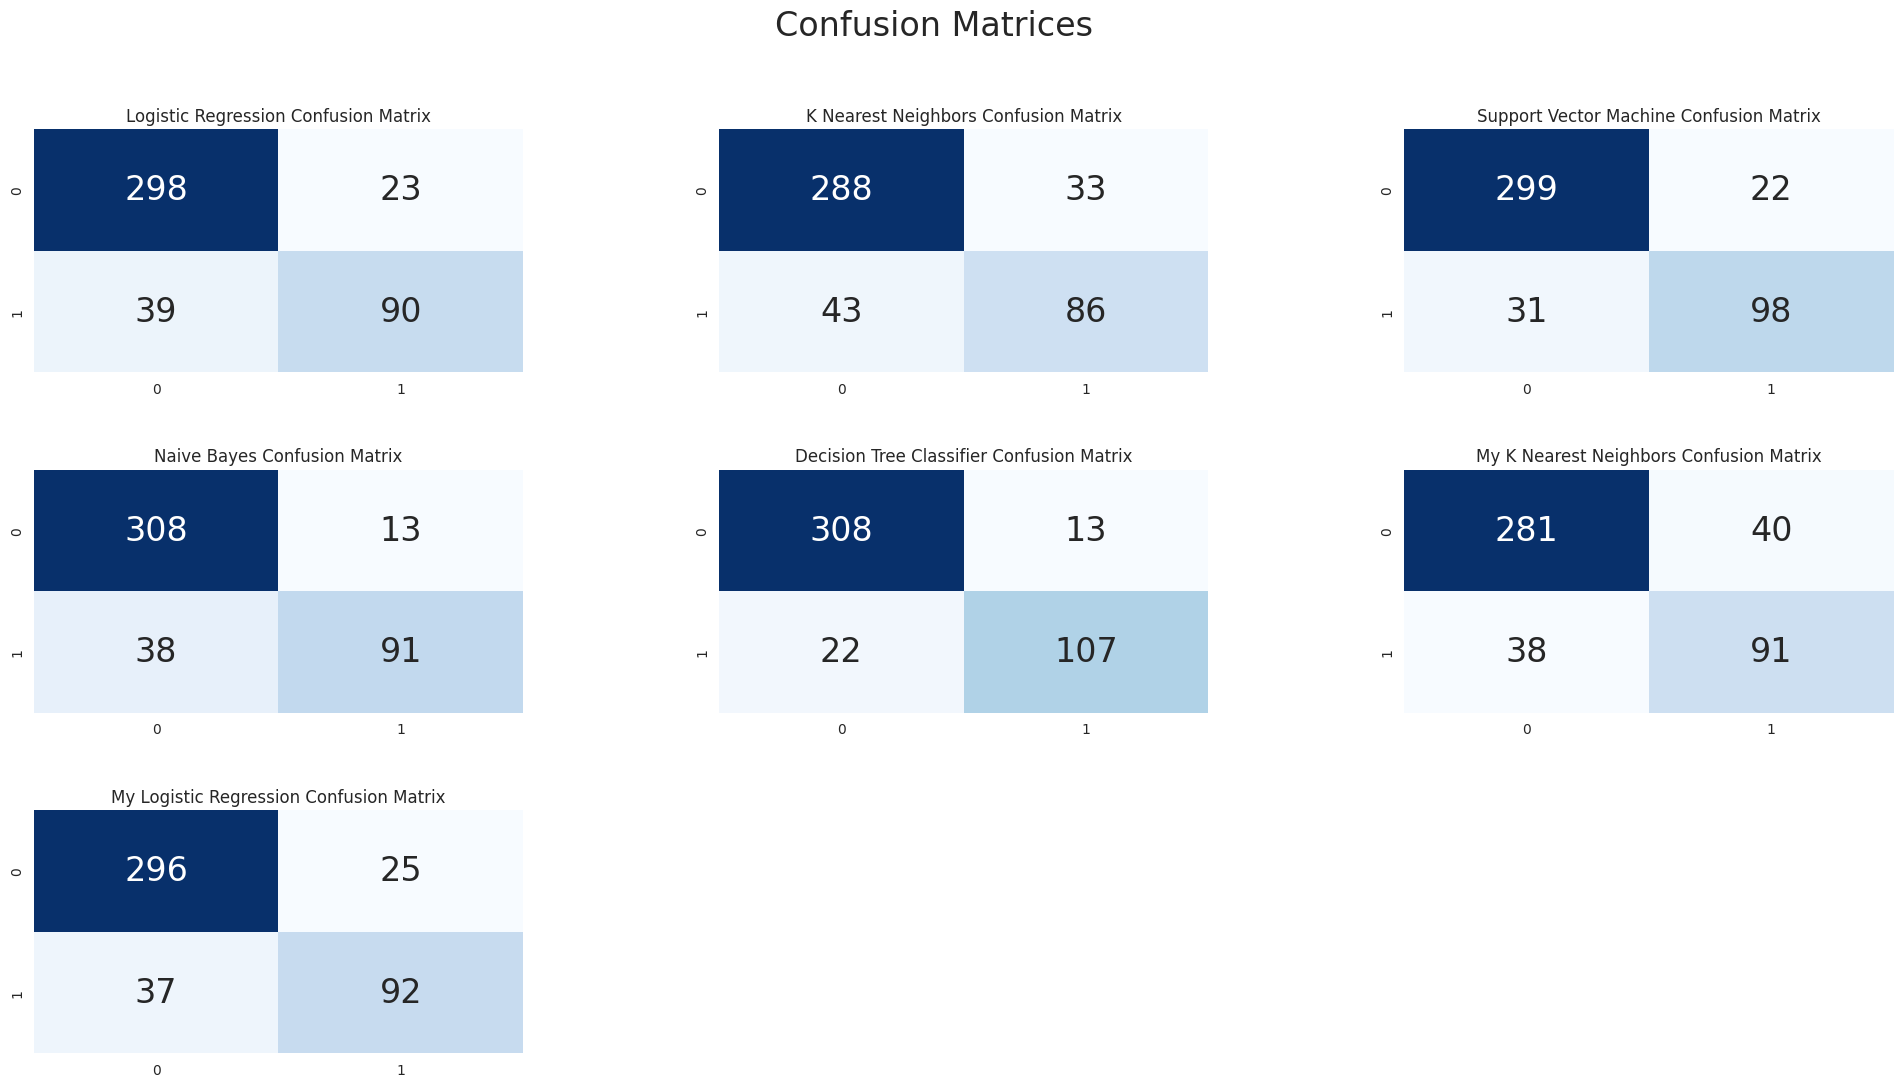

In [28]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("My K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_myknn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,7)
plt.title("My Logistic Regression Confusion Matrix")
sns.heatmap(cm_mylr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

- Для этих данных лучшим алгоритмом оказалось дерево решений
- Хуже всего себя показала KNN (вновь моя реализация хуже библиотечной)
- Наивный Байес, несмотря на наивность, занимает второе место 
- SVM занимает третье место
- Логистическая регрессия на четвертом, причем моя реализация показала идентичную точность с библиотечной реализацией
